# IEEE Fraud Detection

## 0. Project Description

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

Acknowledgements:

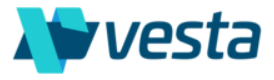

Vesta Corporation provided the dataset for this competition. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually.

Header Photo by Tim Evans on Unsplash

https://www.kaggle.com/pyonemyatmaw/ieee-cis-xgb-lgb

## 1. Loading packages and reading in data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras import regularizers

In [2]:
train_ID=pd.read_csv('ieee-fraud-detection/train_identity.csv') 
train_trans=pd.read_csv('ieee-fraud-detection/train_transaction.csv')
test_ID=pd.read_csv('ieee-fraud-detection/test_identity.csv') 
test_trans=pd.read_csv('ieee-fraud-detection/test_transaction.csv')

# 2. looking at the data

In [3]:
print(train_ID.shape)
print(train_trans.shape)
print(test_ID.shape)
print(test_trans.shape)

(144233, 41)
(590540, 394)
(141907, 41)
(506691, 393)


### 2.1 Reduce memory usage 
__note:__ we see these are very big datasets. We'll try to reduce the memory usage to lower the chance on a memory error.

In [4]:
# reduce memory data function
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train_ID = reduce_mem_usage(train_ID)
train_trans = reduce_mem_usage(train_trans)
test_ID = reduce_mem_usage(test_ID)
test_trans = reduce_mem_usage(test_trans)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


### 2.2. merging the datasets

The 2 datasets (identity and transactions) are joined by transactionID. We merge them, so we get a training dataset and a testing dataset. Not all transactions have a matching identity, so we do a left join (like SQL) on the transactions.

In [6]:
train_set = train_trans.merge(train_ID, on='TransactionID', how='left')
test_set = test_trans.merge(test_ID, on='TransactionID', how='left')

We will look for differnces in the features between the training and test set.

In [7]:
differences = list(set(train_set.columns) - set(test_set.columns))
print("difference is: ", differences)

difference is:  ['id_21', 'id_31', 'id_19', 'id_11', 'id_16', 'id_08', 'id_05', 'id_12', 'id_38', 'id_14', 'id_01', 'id_27', 'id_13', 'id_33', 'id_36', 'id_35', 'id_17', 'id_29', 'id_24', 'id_20', 'id_04', 'isFraud', 'id_07', 'id_23', 'id_26', 'id_10', 'id_32', 'id_18', 'id_09', 'id_37', 'id_25', 'id_22', 'id_06', 'id_03', 'id_02', 'id_34', 'id_15', 'id_30', 'id_28']


We see the column names of the id's are spelled different. We will change the column names and make a last control.

In [8]:
test_set.rename({'id-01':'id_01','id-02':'id_02','id-03':'id_03','id-04':'id_04','id-05':'id_05', \
                  'id-06':'id_06','id-07':'id_07','id-08':'id_08','id-09':'id_09','id-10':'id_10', \
                  'id-11':'id_11','id-12':'id_12','id-13':'id_13','id-14':'id_14','id-15':'id_15', \
                  'id-16':'id_16','id-17':'id_17','id-18':'id_18','id-19':'id_19','id-20':'id_20', \
                  'id-21':'id_21','id-22':'id_22','id-23':'id_23','id-24':'id_24','id-25':'id_25', \
                  'id-26':'id_26','id-27':'id_27','id-28':'id_28','id-29':'id_29','id-30':'id_30', \
                  'id-31':'id_31', 'id-32':'id_32', 'id-33':'id_33', 'id-34':'id_34', 'id-35':'id_35', \
                  'id-36':'id_36', 'id-37':'id_37', 'id-38':'id_38'},axis=1, inplace=True)
differences = list(set(train_set.columns) - set(test_set.columns))
print("difference is: ", differences)

difference is:  ['isFraud']


In [9]:
train_set = train_set.head(50000).copy()
test_set = test_set.head(50000).copy()

### 2.3. Changing Dtypes of some features

They tell us that next features are categorical, so we will change them: 
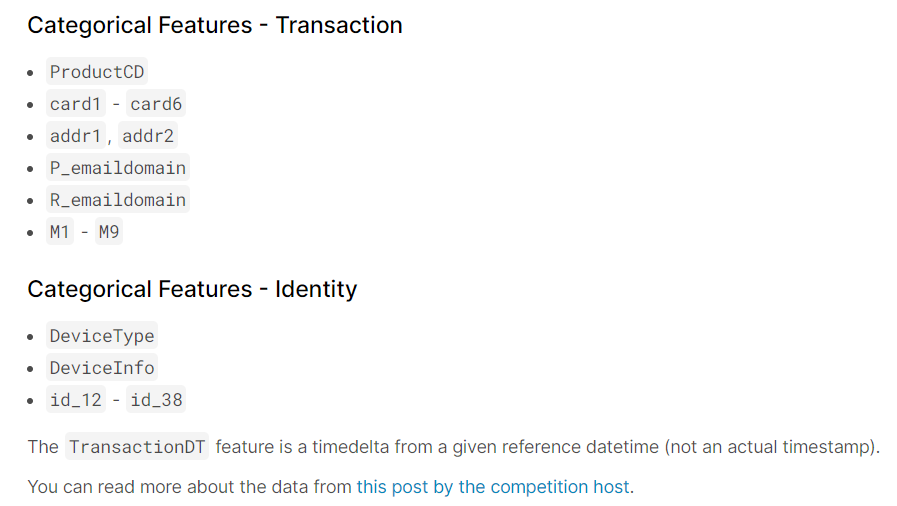

In [10]:
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',\
           'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo',\
           'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',\
           'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',\
           'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
for col in cat_cols:
    train_set[col] = train_set[col].astype('category')
    test_set[col] = test_set[col].astype('category')

Now we'll control if it happend.

In [11]:
 train_set[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ProductCD      50000 non-null  category
 1   card1          50000 non-null  category
 2   card2          49303 non-null  category
 3   card3          49997 non-null  category
 4   card4          49994 non-null  category
 5   card5          49765 non-null  category
 6   card6          49997 non-null  category
 7   addr1          47409 non-null  category
 8   addr2          47409 non-null  category
 9   P_emaildomain  41014 non-null  category
 10  R_emaildomain  11660 non-null  category
 11  M1             17967 non-null  category
 12  M2             17967 non-null  category
 13  M3             17967 non-null  category
 14  M4             22662 non-null  category
 15  M5             17826 non-null  category
 16  M6             31329 non-null  category
 17  M7             9224 non-null   

In [12]:
test_set[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ProductCD      50000 non-null  category
 1   card1          50000 non-null  category
 2   card2          49501 non-null  category
 3   card3          49998 non-null  category
 4   card4          49975 non-null  category
 5   card5          49877 non-null  category
 6   card6          49998 non-null  category
 7   addr1          45404 non-null  category
 8   addr2          45404 non-null  category
 9   P_emaildomain  42242 non-null  category
 10  R_emaildomain  8858 non-null   category
 11  M1             36955 non-null  category
 12  M2             36955 non-null  category
 13  M3             36955 non-null  category
 14  M4             27196 non-null  category
 15  M5             22316 non-null  category
 16  M6             39377 non-null  category
 17  M7             29849 non-null  

The 'is_fraud' feature exists only of 0 and 1. We'll make a category of it too. (test set has no 'isFraud')

In [13]:
train_set['isFraud'] = train_set['isFraud'].astype('uint8').astype('category')

### 2.4. Looking at the descriptives and countplots

In [14]:
train_set.iloc[:,0:15].describe(include="all")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2
count,5.000000e+04,50000.0,5.000000e+04,5.000000e+04,50000,50000.0,49303.0,49997.0,49994,49765.0,49997,47409.0,47409.0,16880.0,3355.0
unique,NaN,2.0,NaN,NaN,5,5446.0,497.0,58.0,4,74.0,4,255.0,36.0,NaN,NaN
top,NaN,0.0,NaN,NaN,W,7919.0,321.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN
freq,NaN,48643.0,NaN,NaN,32798,1750.0,4035.0,45067.0,32561,25798.0,34205,4164.0,45016.0,NaN,NaN
mean,3.012000e+06,NaN,6.377990e+05,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf
std,1.443390e+04,NaN,3.229399e+05,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf
min,2.987000e+06,NaN,8.640000e+04,2.919922e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
25%,2.999500e+06,NaN,3.522868e+05,4.200000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,7.0
50%,3.012000e+06,NaN,6.537475e+05,6.850000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,30.0
75%,3.024499e+06,NaN,9.321258e+05,1.200000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,229.0


In [15]:
train_set.iloc[:,15:30].describe(include="all")

,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13
count,41014,11660,50000.0,50000.0,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0000,50000.0,50000.0,50000.0,50000.0
unique,59,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,gmail.com,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,17909,4367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,inf,inf,0.016235,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
std,NaN,NaN,inf,inf,0.156006,inf,inf,inf,inf,inf,14.6875,inf,inf,inf,inf
min,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
25%,NaN,NaN,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0000,0.0,1.0,0.0,1.0
50%,NaN,NaN,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0000,0.0,1.0,0.0,2.0
75%,NaN,NaN,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,1.0,2.0000,1.0,2.0,0.0,12.0


In [16]:
train_set.iloc[:,30:45].describe(include="all")

,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
count,50000.0,50000.0,23484.0,24444.0,26829.0,17821.0,4825.0,2356.0,8750.000000,8750.000000,37830.0,15298.0,4097.0,3678.0,4328.0
mean,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.562988,inf,inf,inf,inf,inf
std,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.315430,inf,inf,inf,inf,inf
min,0.0,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-33.0,-83.0,0.0,-193.0
25%,1.0,0.0,28.0,1.0,0.0,1.0,0.0,0.0,5.679688,0.208374,0.0,0.0,0.0,0.0,0.0
50%,1.0,0.0,106.0,8.0,32.0,11.0,0.0,0.0,66.875000,0.666504,23.0,30.0,0.0,0.0,0.0
75%,2.0,102.0,278.0,28.0,261.0,31.0,51.0,35.0,239.250000,0.791504,210.0,232.0,20.0,0.0,0.0
max,784.0,636.0,636.0,616.0,700.0,656.0,708.0,673.0,1135.000000,0.958496,705.0,499.0,498.0,710.0,708.0


In [17]:
train_set.iloc[:,45:60].describe(include="all")

,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5
count,33499.0,17967,17967,17967,22662,17826,31329,9224,9224,9224,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000
unique,NaN,1,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN
top,NaN,T,T,T,M0,F,F,F,F,T,NaN,NaN,NaN,NaN,NaN
freq,NaN,17967,16168,14030,14864,9749,17030,7933,5684,7888,NaN,NaN,NaN,NaN,NaN
mean,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999512,1.023438,1.049805,0.812500,0.842285
std,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018066,0.168823,0.251221,0.435791,0.467773
min,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
50%,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
75%,319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
train_set.iloc[:,60:75].describe(include="all")

,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
count,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,15298.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000
mean,1.027344,1.050781,1.015625,1.029297,0.478760,0.493164,0.497070,0.538086,1.000000,0.093140,0.105408,0.104980,0.114441,0.741211,0.791504
std,0.182861,0.259277,0.138550,0.192139,0.516602,0.547852,0.512207,0.535156,0.022995,0.342773,0.451660,0.376709,0.429932,0.507812,0.597656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,5.000000,5.000000,6.000000,6.000000,3.000000,4.000000,3.000000,4.000000,1.000000,7.000000,15.000000,15.000000,15.000000,7.000000,15.000000


In [19]:
train_set.iloc[:,75:90].describe(include="all")

,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35
count,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,37826.000000,26828.000000
mean,0.099915,0.108826,1.046875,1.079102,0.921875,0.947266,0.002432,0.002512,0.385254,0.403809,0.112854,0.125366,0.093140,0.105408,0.485107
std,0.322021,0.380127,0.317139,0.426514,0.327148,0.404785,0.049286,0.051117,0.512207,0.550781,0.367188,0.470215,0.333252,0.432129,0.520020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,8.000000,13.000000,13.000000,7.000000,13.000000,1.000000,2.000000,4.000000,5.000000,7.000000,15.000000,7.000000,13.000000,3.000000


In [20]:
train_set.iloc[:,90:105].describe(include="all")

,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
count,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000,26828.000000
mean,0.519531,1.071289,1.111328,0.173950,0.181152,0.999023,0.164551,0.174438,1.070312,1.102539,1.026367,1.043945,0.383545,0.397217,0.171631
std,0.541504,0.390625,0.520020,0.438232,0.463379,0.036102,0.385986,0.427246,0.357178,0.422363,0.180542,0.241333,0.512695,0.542480,0.379883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,11.000000,14.000000,10.000000,10.000000,1.000000,3.000000,6.000000,12.000000,12.000000,4.000000,6.000000,3.000000,5.000000,3.000000


In [21]:
train_set.iloc[:,105:120].describe(include="all")

,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65
count,26828.000000,26828.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000
mean,0.160156,0.165527,0.499756,0.541016,1.042969,1.075195,0.111267,0.113586,0.113892,0.117981,0.750000,0.791016,0.109497,0.115051,0.999512
std,0.391602,0.415771,0.510254,0.530762,0.299561,0.407715,0.327881,0.337158,0.346924,0.362061,0.481689,0.520020,0.321777,0.343994,0.019791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,4.000000,6.000000,5.000000,5.000000,14.000000,15.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,4.000000,5.000000,1.000000


In [22]:
train_set.iloc[:,120:135].describe(include="all")

,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80
count,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,38282.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000
mean,0.916016,0.936035,0.001436,0.380371,0.396973,0.122864,0.125244,0.114075,0.118713,0.494873,0.536133,1.050781,1.083984,0.125854,0.147095
std,0.314453,0.337646,0.037872,0.514648,0.549805,0.342773,0.351807,0.342285,0.366943,0.515137,0.535645,0.356934,0.449951,0.351562,0.402832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,5.000000,8.000000,1.000000,4.000000,5.000000,6.000000,7.000000,5.000000,8.000000,3.000000,4.000000,11.000000,12.000000,5.000000,8.000000


In [23]:
train_set.iloc[:,135:150].describe(include="all")

,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
count,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.000000,33496.00000,33496.000000,33496.000000,33496.000000,50000.000000
mean,0.150879,0.821777,0.862793,0.139404,0.145142,1.053711,1.083984,0.998535,0.002836,0.409668,0.42749,0.150146,0.151733,0.120605,0.232910
std,0.416260,0.443604,0.483154,0.356934,0.379883,0.317139,0.376709,0.034546,0.053741,0.521484,0.56250,0.373047,0.380371,0.325684,0.792969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
max,8.000000,5.000000,6.000000,3.000000,5.000000,10.000000,10.000000,1.000000,2.000000,4.000000,5.00000,5.000000,5.000000,1.000000,17.000000


In [24]:
train_set.iloc[:,150:165].describe(include="all")

,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.108398,0.459961,0.056854,0.604980,0.181396,0.119019,0.389648,0.207520,0.055267,0.112305,0.069092,0.999512,1.003906,1.009766,1.004883
std,4.226562,1.638672,0.257812,1.722656,0.631836,0.609863,2.966797,1.260742,0.317627,0.806152,0.431885,0.000488,0.067383,0.097839,0.077515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,86.000000,37.000000,5.000000,34.000000,16.000000,16.000000,72.000000,34.000000,7.000000,36.000000,18.000000,1.000000,4.000000,4.000000,4.000000


In [25]:
train_set.iloc[:,165:180].describe(include="all")

,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.003906,1.005859,1.003906,1.007812,1.016602,1.010742,1.001953,1.001953,1.001953,1.002930,1.003906,1.002930,1.027344,1.062500,1.036133
std,0.068909,0.076660,0.071594,0.095154,0.142212,0.108948,0.042389,0.044891,0.043304,0.049164,0.057709,0.051147,0.210938,0.304443,0.235474
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,10.000000,10.000000,10.000000


In [26]:
train_set.iloc[:,180:195].describe(include="all")

,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140
count,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,12213.000000,12213.000000,12213.000000
mean,37.912209,127.153961,64.632362,inf,inf,inf,18.988361,49.898525,31.557068,10.702315,17.817450,12.553886,0.018173,0.686035,0.705566
std,325.809662,628.438538,425.309204,inf,inf,inf,172.833359,433.363953,289.123474,246.507965,266.684784,250.872192,0.229980,1.083984,1.130859
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,59.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,50820.000000,50820.000000,50820.000000,3894.0,4676.0,4676.0,7985.000000,15227.000000,11260.000000,50820.000000,50820.000000,50820.000000,8.000000,18.000000,18.000000


In [27]:
train_set.iloc[:,195:210].describe(include="all")

,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155
count,12213.000000,12213.000000,1.221300e+04,1.221300e+04,12213.000,12213.000000,12213.000000,12213.000000,12213.000000,12213.0,1.221300e+04,12213.000,12213.000000,12213.000000,12213.000000
mean,0.024811,0.030701,inf,inf,inf,0.080261,0.082275,0.508301,0.510254,inf,inf,inf,0.503906,0.505371,0.511719
std,0.187988,0.249390,1.349219e+01,1.610938e+01,87.125,0.427246,0.434082,0.541016,0.545898,inf,2.554688e+01,32.125,0.529297,0.536133,0.554688
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000e+00,1.000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000e+00,1.000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000e+00,1.000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.300000e+01,2.600000e+01,144.000,0.000000,0.000000,1.000000,1.000000,2308.0,5.200000e+01,65.000,1.000000,1.000000,1.000000
max,5.000000,6.000000,4.900000e+01,5.300000e+01,245.000,7.000000,8.000000,6.000000,6.000000,3340.0,5.700000e+01,68.000,6.000000,8.000000,7.000000


In [28]:
train_set.iloc[:,210:225].describe(include="all")

,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170
count,12213.000000,12213.000000,12213.000000,12213.0,12213.000000,1.221300e+04,1.221300e+04,1.221300e+04,12213.000000,12213.000000,12213.000000,15251.000000,15251.000000,15251.000000,15251.000000
mean,0.514648,0.532715,0.537598,inf,148280.937500,2.871094e+00,3.949219e+00,3.189453e+00,806.819458,4616.966309,1110.120239,0.380859,0.658691,0.100281,1.256836
std,0.564941,0.598633,0.613770,inf,181355.890625,inf,inf,inf,1014.393921,5690.677734,1718.962158,1.211914,3.308594,0.605957,1.011719
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,25632.0,318223.625000,0.000000e+00,0.000000e+00,0.000000e+00,1689.949951,10030.000000,2278.979980,0.000000,0.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,44192.0,512182.500000,1.000000e+03,1.300000e+03,1.000000e+03,6300.000000,15265.000000,101640.000000,17.000000,63.000000,11.000000,18.000000


In [29]:
train_set.iloc[:,225:240].describe(include="all")

,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
count,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000
mean,1.315430,0.076660,0.040710,0.073608,0.090942,1.129883,0.176636,0.467285,0.268799,0.313232,0.113220,0.249390,0.148682,0.104004,0.106934
std,1.220703,0.407959,0.220581,0.304199,0.449707,0.677246,0.791992,3.445312,1.439453,2.050781,0.473145,1.490234,0.727051,0.448975,0.459717
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.000000,8.000000,3.000000,5.000000,8.000000,13.000000,16.000000,66.000000,29.000000,29.000000,6.000000,19.000000,14.000000,7.000000,8.000000


In [30]:
train_set.iloc[:,240:255].describe(include="all")

,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
count,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000
mean,1.068359,1.448242,0.979492,0.995117,1.083008,1.041992,1.190430,1.113281,0.961426,0.966309,1.053711,0.970215,0.975586,1.117188,1.022461
std,0.514648,4.910156,0.324219,0.505371,0.562500,0.397949,2.039062,1.204102,0.271729,0.291260,0.463623,0.301270,0.329834,0.644531,0.456543
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11.000000,85.000000,7.000000,15.000000,12.000000,9.000000,34.000000,23.000000,6.000000,8.000000,10.000000,7.000000,9.000000,13.000000,10.000000


In [31]:
train_set.iloc[:,255:270].describe(include="all")

,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215
count,15251.000000,15251.000000,15251.000000,15251.000000,15251.0,15251.0,15251.0,15251.0,15251.0,15251.0,15251.000000,15251.000000,15251.000000,15251.000000,15251.000000
mean,1.045898,60.118832,277.478363,123.974892,inf,inf,inf,inf,inf,inf,20.391985,118.299820,42.831886,26.470545,62.338638
std,0.637695,954.388489,2985.113281,1361.162476,inf,inf,inf,inf,inf,inf,136.290451,1444.850708,409.004974,925.724304,1014.730957
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,101640.000000,101640.000000,101640.000000,2550.0,1500.0,8076.0,1000.0,8048.0,1450.0,6300.000000,66000.000000,14200.000000,101640.000000,101640.000000


In [32]:
train_set.iloc[:,270:285].describe(include="all")

,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230
count,15251.000000,15157.000000,15157.000000,15157.000000,15551.000000,15551.000000,15551.000000,15157.000000,15157.000000,15157.000000,15157.000000,15551.000000,15157.000000,15157.000000,15157.000000
mean,37.185570,0.429443,1.700195,0.820801,0.096924,1.172852,1.223633,0.102783,0.878418,0.354736,0.136475,0.097961,1.165039,2.060547,1.444336
std,944.747925,1.446289,14.250000,4.992188,0.635742,1.692383,1.827148,0.702148,9.085938,3.310547,2.287109,1.190430,0.928711,11.312500,4.035156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,101640.000000,20.000000,219.000000,79.000000,15.000000,92.000000,92.000000,16.000000,144.000000,51.000000,242.000000,84.000000,19.000000,176.000000,65.000000


In [33]:
train_set.iloc[:,285:300].describe(include="all")

,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245
count,15157.000000,15157.000000,15157.000000,15551.000000,15157.000000,15157.000000,15157.000000,15551.000000,15551.000000,15157.000000,15157.000000,15157.000000,15157.000000,15157.000000,15551.000000
mean,0.198486,0.466064,0.277100,1.070312,0.117126,0.319824,0.174927,0.101318,0.104614,1.000977,1.000000,1.096680,1.322266,1.098633,0.904297
std,0.943848,3.005859,1.347656,6.921875,0.483887,2.359375,0.931152,0.459473,0.469727,0.030380,0.014069,0.772949,3.449219,0.790039,1.197266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,17.000000,42.000000,22.000000,70.000000,7.000000,34.000000,16.000000,11.000000,11.000000,2.000000,2.000000,18.000000,57.000000,18.000000,80.000000


In [34]:
train_set.iloc[:,300:315].describe(include="all")

,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260
count,15157.000000,15157.000000,15157.000000,15157.000000,15551.000000,15551.000000,15157.000000,15157.000000,15157.000000,15551.000000,15551.000000,15157.000000,15157.000000,15551.000000,15157.000000
mean,1.110352,1.052734,1.217773,1.126953,0.863770,0.868164,1.078125,1.833008,1.326172,0.886230,0.893555,1.152344,1.428711,0.946289,0.969727
std,0.803223,0.511719,2.435547,1.361328,0.407959,0.421143,0.730957,10.421875,3.812500,0.796875,0.808105,0.901855,4.054688,1.287109,0.334473
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,18.000000,12.000000,36.000000,22.000000,8.000000,8.000000,18.000000,163.000000,60.000000,46.000000,46.000000,18.000000,66.000000,84.000000,5.000000


In [35]:
train_set.iloc[:,315:330].describe(include="all")

,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275
count,15157.000000,15157.000000,15157.000000,15157.000000,15157.000000,15157.0,15157.0,15157.0,15157.0,15551.0,15551.0,15551.0,15157.0,15157.000000,15157.0
mean,1.235352,1.054688,61.763264,417.893066,162.497574,inf,inf,inf,inf,inf,inf,inf,inf,163.949814,inf
std,2.992188,1.087891,955.751587,4837.699707,1930.262329,inf,inf,inf,inf,inf,inf,inf,inf,1962.673096,inf
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
max,49.000000,20.000000,101640.000000,101640.000000,101640.000000,2300.0,27008.0,12552.0,2300.0,1300.0,1300.0,1300.0,6300.0,66000.000000,20848.0


In [36]:
train_set.iloc[:,330:345].describe(include="all")

,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290
count,15157.000000,15157.000000,15157.000000,49989.000000,49989.000000,50000.000000,50000.000000,50000.000000,49989.000000,49989.000000,49989.000000,49989.000000,50000.000000,50000.000000,49989.000000
mean,28.513453,96.634651,50.147686,0.301025,0.787598,0.075500,0.832031,1.026367,0.076294,0.955078,0.028152,0.294922,0.155396,0.202026,1.077148
std,931.554932,1292.671753,992.961121,1.090820,4.574219,0.451416,0.853516,2.203125,0.300049,2.138672,0.177856,0.805664,0.395996,0.550293,0.621094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,101640.000000,101640.000000,101640.000000,36.000000,196.000000,10.000000,13.000000,68.000000,5.000000,34.000000,4.000000,16.000000,5.000000,7.000000,34.000000


In [37]:
train_set.iloc[:,345:360].describe(include="all")

,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305
count,49989.0,49989.000000,49989.000000,4.998900e+04,49989.000000,50000.000000,49989.000000,49989.000000,49989.000000,50000.000000,50000.000000,49989.000000,49989.000000,49989.000000,49989.000000
mean,inf,1.235352,0.162476,9.985352e-01,0.401611,0.192993,0.059448,0.159180,0.087219,0.046387,0.049286,0.315430,0.336182,0.322266,1.000000
std,inf,3.718750,0.920898,inf,4.210938,1.671875,0.346680,1.255859,0.556152,0.284912,0.294189,0.488525,0.572266,0.506836,0.006325
min,1.0,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.0,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.0,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.0,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,874.0,186.000000,36.000000,8.340000e+02,196.000000,61.000000,9.000000,47.000000,19.000000,7.000000,7.000000,7.000000,17.000000,7.000000,2.000000


In [38]:
train_set.iloc[:,360:375].describe(include="all")

,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320
count,49989.000000,49989.000000,49989.000000,49989.0,49989.0000,49989.0,49989.0,50000.0,50000.0,50000.0,49989.000000,49989.000000,49989.000000,49989.000000,49989.000000
mean,48.756142,224.192764,104.843536,inf,inf,inf,inf,inf,inf,inf,25.503828,105.383667,55.786003,13.493475,25.088392
std,575.531189,1634.083374,813.625671,inf,inf,inf,inf,inf,inf,inf,221.025864,1401.844116,574.913940,518.030273,535.735168
min,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,117.000000,20.000000,0.0,78.9375,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,101640.000000,101640.000000,101640.000000,3162.0,19808.0000,3162.0,3162.0,3956.0,5020.0,3956.0,7985.000000,66000.000000,18560.000000,101640.000000,101640.000000


In [39]:
train_set.iloc[:,375:390].describe(include="all")

,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335
count,49989.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.00,12268.0
mean,16.797197,0.262695,0.571289,0.365723,0.031860,0.262939,0.106140,0.103516,0.151001,0.110474,38.942390,63.051811,45.816238,4.25,inf
std,520.974182,0.915527,2.656250,1.336914,0.210693,1.925781,0.707031,0.458008,0.820312,0.469727,190.456024,446.416718,210.330963,inf,inf
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
max,101640.000000,16.000000,42.000000,26.000000,5.000000,34.000000,11.000000,7.000000,14.000000,7.000000,6300.000000,32250.000000,6300.000000,1000.00,2700.0


In [40]:
train_set.iloc[:,390:405].describe(include="all")

,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
count,12268.0,12268.000000,12268.000000,12268.000000,1.645600e+04,16069.000000,7456.000000,7456.000000,15605.000000,1.560500e+04,607.000000,607.00000,8750.000000,8750.000000,1.606900e+04
mean,inf,15.742602,21.362671,16.464481,-inf,133358.390625,0.107544,-0.070801,1.889648,-inf,13.359375,-40.96875,0.140503,-0.393311,inf
std,inf,91.084587,131.079559,92.730209,1.403906e+01,123074.875000,0.700195,0.726562,5.230469,1.604688e+01,10.851562,29.31250,1.108398,3.318359,1.254883e+00
min,0.0,0.000000,0.000000,0.000000,-1.000000e+02,1120.000000,-9.000000,-13.000000,-30.000000,-1.000000e+02,-16.000000,-100.00000,-23.000000,-100.000000,9.000000e+01
25%,0.0,0.000000,0.000000,0.000000,-5.000000e+00,52145.000000,0.000000,0.000000,0.000000,-4.000000e+00,4.000000,-51.50000,0.000000,0.000000,1.000000e+02
50%,0.0,0.000000,0.000000,0.000000,-5.000000e+00,97665.000000,0.000000,0.000000,0.000000,0.000000e+00,14.000000,-33.00000,0.000000,0.000000,1.000000e+02
75%,0.0,0.000000,0.000000,0.000000,0.000000e+00,171732.000000,0.000000,0.000000,1.000000,0.000000e+00,22.000000,-21.00000,0.000000,0.000000,1.000000e+02
max,1300.0,1700.000000,3000.000000,1700.000000,0.000000e+00,998295.000000,9.000000,0.000000,52.000000,0.000000e+00,41.000000,0.00000,14.000000,0.000000,1.000000e+02


In [41]:
train_set.iloc[:,405:420].describe(include="all")

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26
count,16456,12782.0,11894.0,16069,15137,15921.0,4853.0,15917.0,15912.0,604.0,608.0,608,559.0,598.0,608.0
unique,2,36.0,21.0,3,2,49.0,12.0,349.0,164.0,136.0,6.0,3,5.0,122.0,48.0
top,NotFound,52.0,-300.0,Found,NotFound,166.0,15.0,410.0,507.0,252.0,14.0,IP_PROXY:TRANSPARENT,15.0,321.0,161.0
freq,14433,6997.0,6565.0,7786,7681,11828.0,2342.0,1693.0,1828.0,200.0,559.0,329,265.0,199.0,86.0


In [42]:
train_set.iloc[:,420:435].describe(include="all")

,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,608,16069,16069,11673,16048,11674.0,10821,11640,16069,16069,16069,16069,16068,14351
unique,2,2,2,63,73,4.0,89,3,2,2,2,2,2,585
top,Found,Found,Found,Windows 10,chrome 62.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
freq,607,9059,8750,3344,4956,8129.0,2576,9104,11676,14703,12671,13423,10887,6224


# 3. Data cleaning

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Target Class Count'),
 Text(0.5, 1.0, 'Class distribution w.rt target variables')]

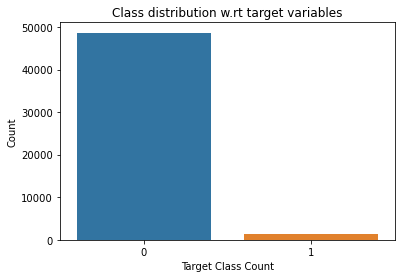

In [43]:
counts = train_set['isFraud'].value_counts().values
ax = sns.barplot([0,1], counts)
ax.set(title='Class distribution w.rt target variables', xlabel = 'Target Class Count', ylabel='Count')

In [44]:
train_set.isnull().sum()[train_set.isnull().sum() != 0]

card2           697
card3             3
card4             6
card5           235
card6             3
              ...  
id_36         33931
id_37         33931
id_38         33931
DeviceType    33932
DeviceInfo    35649
Length: 359, dtype: int64

### 3.1. split-up categorical and numerical features
__note:__ We see that there is almost missing data in e every feature. Before we can scale and impute our numerical and one-hot-encode our categorical features, we have to know which are wich ones.

In [45]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(50), float16(337), float32(45), int32(2)
memory usage: 44.5 MB


In [46]:
num_cols = [cname for cname in train_set.columns if 
                  train_set[cname].dtype in ['int32', 'float16', 'float32']]

cat_cols = [cname for cname in train_set.columns if
                   train_set[cname].dtype.name == "category"]

In [47]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(50), float16(337), float32(45), int32(2)
memory usage: 44.5 MB


### 3.2. Transform the data

+ __Categorical data:__ Make dummies for every feature. 
+ __Numerical data:__ Make a pipeline with a imputer to fill all missing data. We'll also scale the data.

In [48]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

trainset = train_set.copy()
testset = test_set.copy()

#Preprocessing for categorical data
for col in cat_cols:
    if col != 'isFraud':
        dummies = pd.get_dummies(trainset[col], dummy_na=False, prefix=col)
        trainset = pd.concat([trainset, dummies],axis=1)                   
        trainset.drop(columns=[col], inplace=True)  
        
        testset = pd.concat([testset, dummies], axis=1)
        testset.drop(columns=[col], inplace=True)

#Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

trainset[num_cols] = numeric_transformer.fit_transform(trainset[num_cols])
testset[num_cols] = numeric_transformer.fit_transform(testset[num_cols])

In [49]:
trainset.isnull().sum()[trainset.isnull().sum() != 0]

Series([], dtype: int64)

In [50]:
trainset.shape

(50000, 8689)

In [51]:
testset.shape

(50000, 8688)

# 4. Building auto-encoder

### 4.1. Train - test - val - split

In [52]:
X_train, X_test = train_test_split(trainset, test_size=0.2, random_state=1234)

y_test = X_test['isFraud']
X_test = X_test.drop(['isFraud'], 1)

X_train = X_train[X_train['isFraud'] == 0]
X_train = X_train.drop(['isFraud'], 1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=123)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

We'll check the amount of observations that are flagged as fraud, so we know how much observations we are looking for.

In [53]:
y_val.value_counts()

0    5846
1     154
Name: isFraud, dtype: int64

### 4.2.  Building the auto-encoder model

In [54]:
# the number of features is the input shape
input_dim = X_train.shape[1]

## rate 
rate = 0.2

# encoder model
    ## input layer
input_layer = Input(shape=(input_dim, ))

    ## encoder layers
encoder = Dense(128, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
Dropout(rate)(encoder)
BatchNormalization()(encoder)
encoder = Dense(64, activation="relu")(encoder)
Dropout(rate)(encoder)
BatchNormalization()(encoder)
encoder = Dense(32, activation = 'relu') (encoder)

# decoder model
decoder = Dense(64, activation = "relu") (encoder)
Dropout(rate)(decoder)
BatchNormalization()(encoder)
decoder = Dense(128, activation='relu')(encoder)
Dropout(rate)(decoder)
BatchNormalization()(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# build auto-encoder model 
autoencoder = Model(inputs = input_layer, outputs = decoder)

### 4.3. Compiling and fitting the model

In [55]:
#compile and fit
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import EarlyStopping

nb_epoch = 100
batch_size = 29
early_stopping = EarlyStopping(patience=10)
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

history = autoencoder.fit(X_train, X_train, 
                          epochs = nb_epoch,
                         batch_size = batch_size,
                         shuffle=True,
                         validation_split=0.2,
                         verbose=1,
                         callbacks=[checkpointer, early_stopping])

Epoch 1/100
1074/1074 [==============================] - 32s 29ms/step - loss: 0.0613 - accuracy: 4.3939e-04 - val_loss: 0.0357 - val_accuracy: 0.0037
Epoch 2/100
1074/1074 [==============================] - 30s 28ms/step - loss: 0.0341 - accuracy: 0.0056 - val_loss: 0.0353 - val_accuracy: 0.0030
Epoch 3/100
1074/1074 [==============================] - 24s 22ms/step - loss: 0.0339 - accuracy: 0.0084 - val_loss: 0.0348 - val_accuracy: 0.0267
Epoch 4/100
1074/1074 [==============================] - 25s 23ms/step - loss: 0.0327 - accuracy: 0.0460 - val_loss: 0.0345 - val_accuracy: 0.0123
Epoch 5/100
1074/1074 [==============================] - 27s 25ms/step - loss: 0.0320 - accuracy: 0.0364 - val_loss: 0.0344 - val_accuracy: 0.0444
Epoch 6/100
1074/1074 [==============================] - 25s 23ms/step - loss: 0.0328 - accuracy: 0.0381 - val_loss: 0.0343 - val_accuracy: 0.0460
Epoch 7/100
1074/1074 [==============================] - 30s 28ms/step - loss: 0.0325 - accuracy: 0.0351 - val_los

### 4.4. Predicting/ Reconstructing credit card transactions trainset and testset

In [56]:
predictions_train = autoencoder.predict(X_train)
predictions_val = autoencoder.predict(X_val)

### 4.5. Taking a look at the MSE

In [57]:
from sklearn.metrics import mean_squared_error 

mse_val = mean_squared_error(X_val,predictions_val)
mse_train = mean_squared_error(X_train,predictions_train)
print(mse_train)
print(mse_val)

0.03191511570509188
0.03689375289796546


In [58]:
error_train = np.mean(np.power(X_train - predictions_train, 2), axis=1)
limit = np.percentile(error_train, 97.5)
print(limit)

0.17885801674083593


In [59]:
error_val = np.mean(np.power(X_val - predictions_val, 2), axis=1)
fraud = error_val > limit
fraud.sum()

175

In [60]:
error_val_pd = pd.DataFrame(error_val)
error_val_pd.columns = ['error']
error_val_pd['id'] = range(len(error_val_pd))
error_val_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   error   6000 non-null   float64
 1   id      6000 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 70.4 KB


In [61]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

confusion_mat = confusion_matrix(y_val, fraud)
print(confusion_mat)

[[5696  150]
 [ 129   25]]


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_val, fraud))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5846
           1       0.14      0.16      0.15       154

    accuracy                           0.95      6000
   macro avg       0.56      0.57      0.56      6000
weighted avg       0.96      0.95      0.95      6000



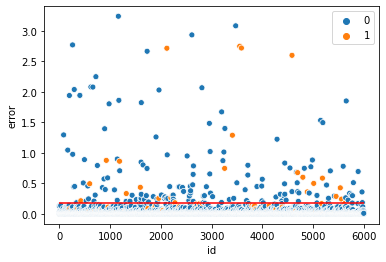

In [63]:
import seaborn as sns
sns.scatterplot(x=error_val_pd.id, y=error_val_pd.error, hue = np.array(y_val))
plt.hlines(limit, 0, len(error_val), colors='r')

In [65]:
predictions_test = autoencoder.predict(X_test)

In [66]:
error_test = np.mean(np.power(X_test - predictions_test, 2), axis=1)
fraud_test = error_test > limit

confusion_mat = confusion_matrix(y_test, fraud_test)
print(confusion_mat)

print(classification_report(y_test, fraud_test))

[[3773  103]
 [ 101   23]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3876
           1       0.18      0.19      0.18       124

    accuracy                           0.95      4000
   macro avg       0.58      0.58      0.58      4000
weighted avg       0.95      0.95      0.95      4000

